In [132]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from feature_engine import encoding as ce
from graph import Linear_Reg_Diagnostic as lrd
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [3]:
# Import data
file_pw = "../data/insurance.csv"

df = pd.read_csv(file_pw)

# Exploratory Data Analysis

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  1338
Number of columns:  7


In [6]:
missing_count = df.isnull().sum().sum()
print("Number of missing entries in the insurance data: ", missing_count)

Number of missing entries in the insurance data:  0


### Variable types

In [7]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Encoding of 'sex', 'smoker' and 'region' is necessary. 

## Distribution and statistic of target column

count     1338.00
mean     13270.42
std      12110.01
min       1121.87
25%       4740.29
50%       9382.03
75%      16639.91
max      63770.43
Name: charges, dtype: float64

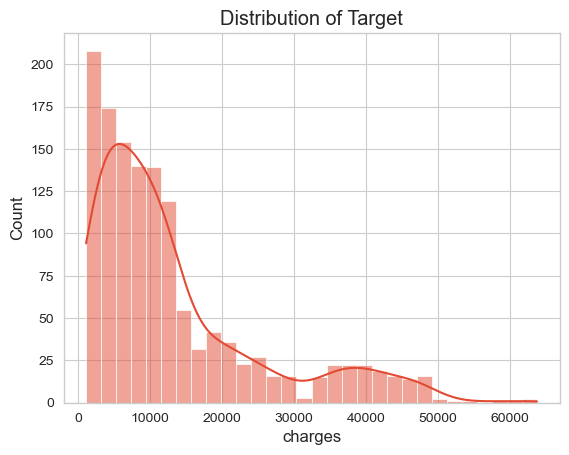

In [8]:
sns.set_style('whitegrid')
charges = sns.histplot(df['charges'],  kde=True)
charges.set(title = "Distribution of Target")
df['charges'].describe().round(2)

Target's distribution is higly right-skewed (median < mean) with mean billing costs of US$ 13,270 and standard deviation of US$ 12,110. It seems that we have a few outliers that may need attention.


In [9]:
def outlier_id(df, column_with_outliers):
    # Creates a column for outliers of the specified column 
    Q1 = df[column_with_outliers].quantile(0.25)
    Q3 = df[column_with_outliers].quantile(0.75)
    IQR = Q3 - Q1

    df[column_with_outliers+"_outliers"] = (df[column_with_outliers] < (Q1 - 1.5 * IQR)) | (df[column_with_outliers] > (Q3 + 1.5 * IQR))

    return df

In [10]:
# For future analysis, I will create an identifier for target outliers
outlier_id(df, 'charges')

,age,sex,bmi,children,smoker,region,charges,charges_outliers
0,19,female,27.900,0,yes,southwest,16884.92400,False
1,18,male,33.770,1,no,southeast,1725.55230,False
2,28,male,33.000,3,no,southeast,4449.46200,False
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,False
1334,18,female,31.920,0,no,northeast,2205.98080,False
1335,18,female,36.850,0,no,southeast,1629.83350,False
1336,21,female,25.800,0,no,southwest,2007.94500,False


In [26]:
df['charges_outliers'] = df['charges_outliers'].astype('str')

## Categorical Features

In [27]:
# List of categorical variables
cat = df.select_dtypes(include=['object', 'bool']).columns.tolist()

### Data entries by category

In [28]:
def plot_label_count(df, categorical_columns):
    size = math.ceil(df[categorical_columns].shape[1]** (1/2))
    fig = plt.figure()
    fig.suptitle('Insured people per category'.title())

    for i, col in enumerate(df[categorical_columns].columns):
        fig.add_subplot(size, size, i + 1)
        df[col].value_counts().plot(kind="bar", ax=plt.gca(),rot=0)
        plt.title(f"{col} variable".title(), fontsize=10)

    fig.tight_layout()

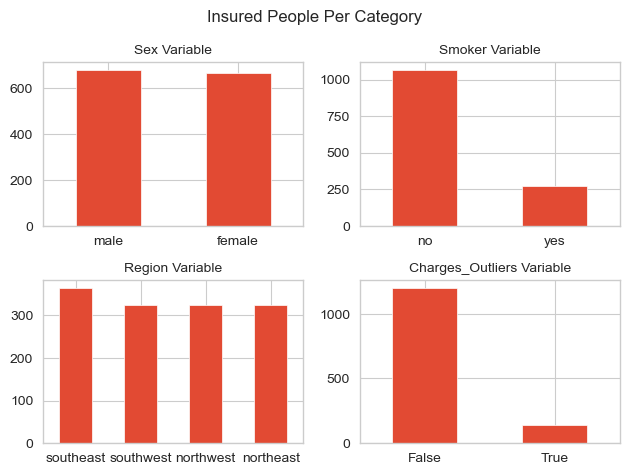

In [29]:
plot_label_count(df, cat)

The sample is well balanced between classes of gender and location, but has mostly non-smokers. 

In [30]:
def target_distribution(df, categorical_columns):
    size = math.ceil(df[categorical_columns].shape[1]** (1/2))
    fig = plt.figure()
    fig.suptitle('Charges distribution per category'.title())

    for i, col in enumerate(df[categorical_columns].columns):
        fig.add_subplot(size, size, i + 1)
        sns.boxplot(x=col, y="charges", data=df,palette='rainbow')
        plt.title(f"{col} variable".title(), fontsize=11)
        plt.xlabel("")
        plt.xticks(rotation=30)
        plt.ylabel("")

    fig.tight_layout()



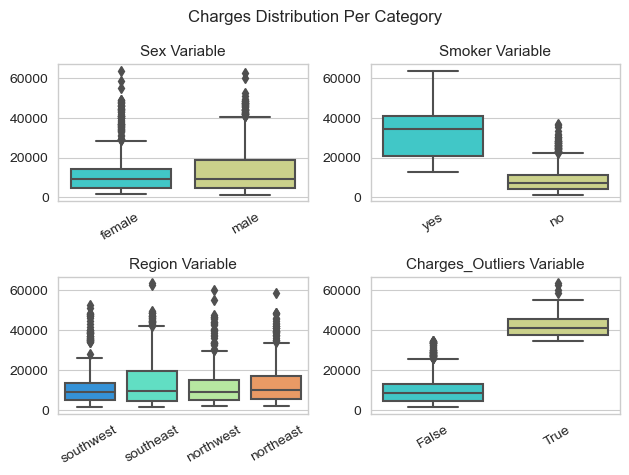

In [31]:
target_distribution(df, cat)

- Male's costs are slightly higher than female's. 
- Smokers tends to represent higher impact on insurance charges.
- Southeast region presents the wider distribution of charges between all. 
- ~10% of data is above U$ 30k.

## Numerical Features

In [32]:
num = [x for x in df.drop(columns='charges').columns if x not in cat]

### Distribution

In [33]:
def plot_distributions(df, numerical_columns):
    f, ax = plt.subplots(ncols=len(numerical_columns), figsize=(17,4))
    f.suptitle("data distribution".title())

    col = 0

    for i, column in enumerate(numerical_columns):   
        g = sns.histplot(df[column], kde=True, ax=ax[col])
        g.set_title(f"Mean={round(df[column].mean(), 2)} - Mode={round(df[column].median(), 2)} - Standard Dev.={round(df[column].std(), 2)}", fontsize=10)
        col += 1

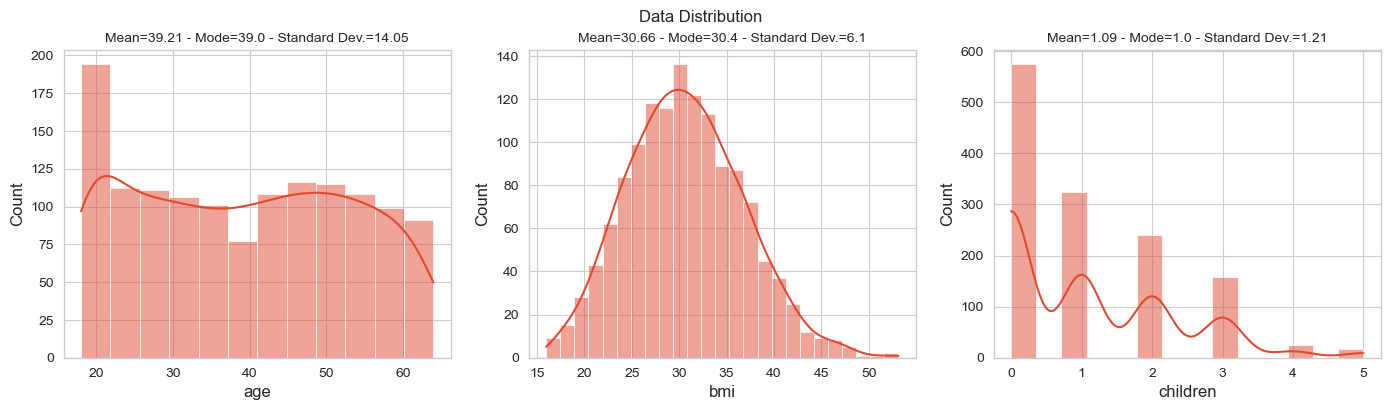

In [34]:
plot_distributions(df, num)

- The age distribution is close to uniform. There is a peak in the sample of people in their 20s.
- Body mass index follows approximately a gaussian distribution. 95% of registers are between 18.46 and 42.86.
- Quantity of children is higly right skewed, which makes sense since birth rate has been falling over time.

### Correlation and Collinearity

In [44]:
def plot_correlations(df):
    corr = df.corr()
    f, ax = plt.subplots(figsize=(6,3))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    htmp = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask = mask, cmap=cmap)
    htmp.set_title('Correlation Heatmap', fontsize=10)
    plt.show()

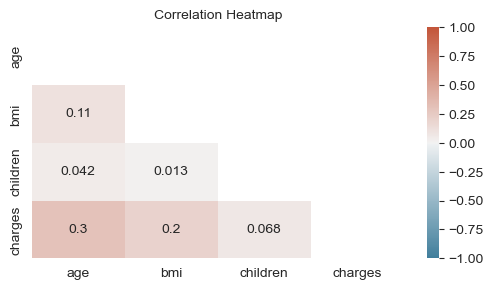

In [36]:
plot_correlations(df)

- Age and bmi are somewhat correlated and impacts charges the most.

In [21]:
def plot_relationship(df, numerical_columns, target_var):
    f, ax = plt.subplots(ncols=len(numerical_columns), figsize=(17,4))
    f.suptitle("Relationship with target variable".title())

    col = 0

    for i, column in enumerate(numerical_columns):  
        g = sns.regplot(x=column, y=target_var, data=df, ax=ax[col]) 
        col += 1

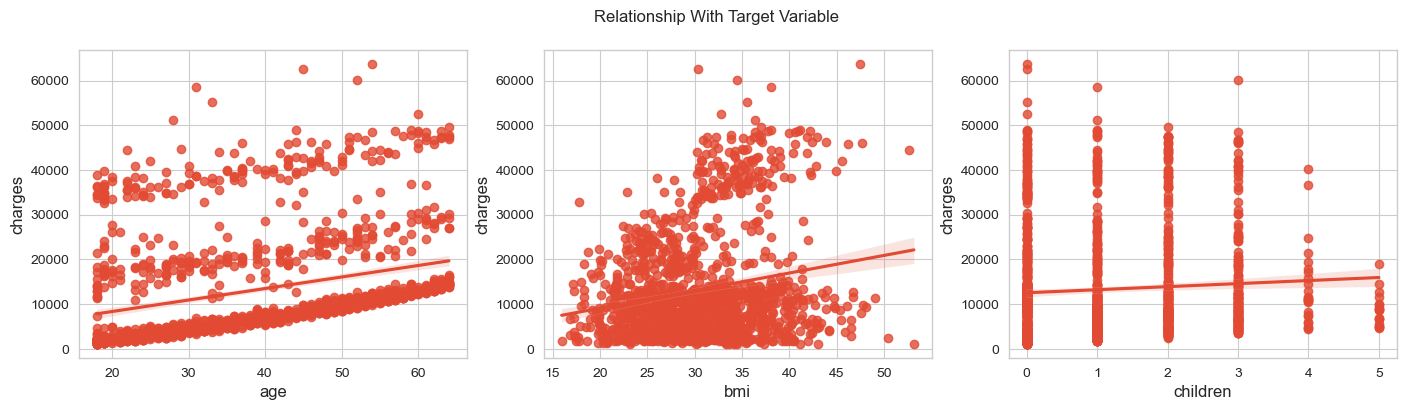

In [22]:
plot_relationship(df, num, 'charges')

- As seen in the correlation matrix, charges tends to increase with all numerical variables.

In [39]:
# Lets compute the variance inflation factor to assess multicollinearity. VIF > 10 indicates a problematic amount of collinearity!
#gather features
features = "+".join(df[num].columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('charges ~' + features, df, return_type='dataframe')

In [40]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Val"] = [VIF(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [43]:
vif.sort_values(by='VIF_Val', ascending=False).iloc[1:,:]

,VIF_Val,features
1,1.013816,age
2,1.012152,bmi
3,1.001874,children


- There is no multicollinearity since all variance inflation factors are bellow 5.

# Data Preprocessing

In [48]:
# Encoding of binary variables
df['smoker'] = np.where(df['smoker'] == 'yes', 1, 0)
df['sex'] = np.where(df['sex'] == 'male', 1, 0)

# Model Fitting

## Hypothesis Testing w/ statsmodels

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['charges', 'charges_outliers']), 
    df['charges'], 
    test_size=0.2, 
    random_state=42
)

In [69]:
# Mean target encoding 'regio' variable
encoder = ce.MeanEncoder(variables=['region'])
encoder.fit(X_train, y_train)

train_data = encoder.transform(X_train)
test_data = encoder.transform(X_test)

c:\Users\lara_\anaconda3\envs\reglin\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MeanEncoder(variables=['region'])

In [101]:
# Adding a column for the constant
train_data = sm.add_constant(train_data)

# Running the model
results = sm.OLS(y_train, train_data).fit()

In [87]:
# Summary of our regression:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     507.1
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          9.56e-308
Time:                        15:29:17   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.187e+04   2999.467     -3.956      0.000   -1.78e+04   -5981.253
age          257.0158     13.481     19.065      0.000     230.563     283.469
sex           -8.4303    376.194     -0.022      0.982    -746.597     729.736
bmi          328.1354     32.002     10.254      0.000     265.341     390.930
children     426.9024    154.660      2.760      0.006     123.428     730.376
smoker      2.366e+04    466.619     50.697      0.000    2.27e+04    2.46e+04
region        -0.0197      0.223     -0.088      0.930      -0.458       0.419
==============================================================================
Omnibus:                      254.125   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.813
Skew:                           1.260   Prob(JB):                    2.57e-135
Kurtosis:                       5.747   Cond. No.                     2.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- F-Statistic from model summary provides information about hypothesis test of the relationship between 'Charges' and predictors. Generally speaking, if none of your independent variables are statistically significant, the overall F-test is also not statistically significant.
    - Null hypothesis: All coefficients are zero.
    - Alternative: At least one coefficient is non-zero.
- Since F-Stat. > 1 and the p-value associated with it is essentially zero, the null hypothesis is rejected and it is proved that at least one predictor has a relationship with the response!
- Two predictors presented high p-value and we can infer from it that there is not an association between them and the predictor. Therefore 'sex' and 'region' will be removed from the regression because of its statistical insignificance.

### Testint Assumptions of Linear Regression
### Linearity Assumption

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

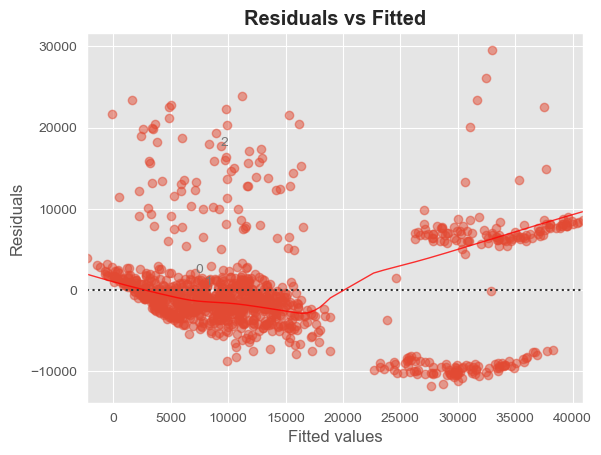

In [118]:
cls = lrd(results)
cls.residual_plot()

- Residual plots is a graphical tool used for identifying non-linearity between predictors and response. Since there is no obvious pattern in the red line, it suggests a linear association in our data.

### Normality Assumption

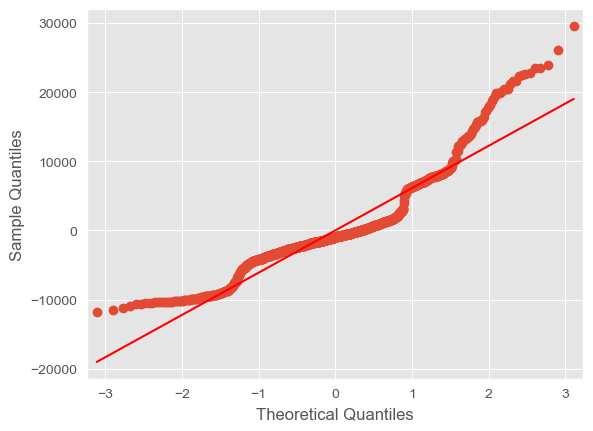

In [98]:
qqplot = sm.qqplot(results.resid, line='s')

- Q-Q plot assesses the normality of residuals distribution. From it we can see that the normality assumption of linear regression models has been violated (the residuals of the model are normally distributed).

### Homoscedasticity Assumption

In [103]:
name = ["Lagrange multiplier statistic", "p-value", "f-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 88.96247860484814),
 ('p-value', 4.9760840627657805e-17),
 ('f-value', 16.065833822962563)]

- From Breusch-Pagan Lagrange Multiplier test we can prove that the residuals have a constant variance. This is important because confidence intervals and hypothesis tests rely upon this assumption.

## Pipeline

In [135]:
df['smoker'] = np.where(df['smoker'] == 1, 'yes', 'no')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['charges', 'charges_outliers', 'sex', 'region']), 
    df['charges'], 
    test_size=0.2, 
    random_state=42
)

In [137]:
model = Pipeline(
    steps=[
        # encode categorical variables
        ('one_hot_encoder', ce.OneHotEncoder(variables = ['smoker'])),
        # scale features
        ('standardscaler', StandardScaler()),
        # linear model
        ('lm', LinearRegression())
    ]
)

In [138]:
model.fit(X_train, y_train)

Pipeline(steps=[('one_hot_encoder', OneHotEncoder(variables=['smoker'])),
                ('standardscaler', StandardScaler()),
                ('lm', LinearRegression())])

In [149]:
pred_test = model.predict(X_test)

In [152]:
print('R^2 - Coefficient of determination: ', round(r2_score(y_test, pred_test), 3))

R^2 - Coefficient of determination:  0.781
